<a href="https://colab.research.google.com/github/NicolasVitorCarvalhodeOliveira/data-analysis-mobile-access-br/blob/new_graphs/analise_de_dados_acesso_mobile_br.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

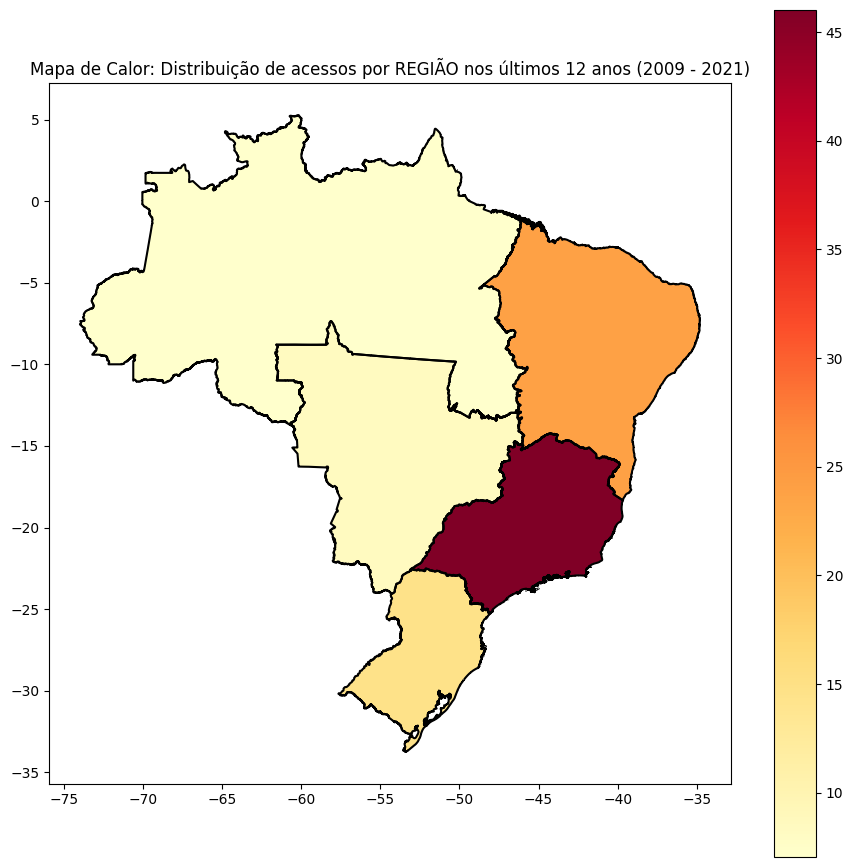

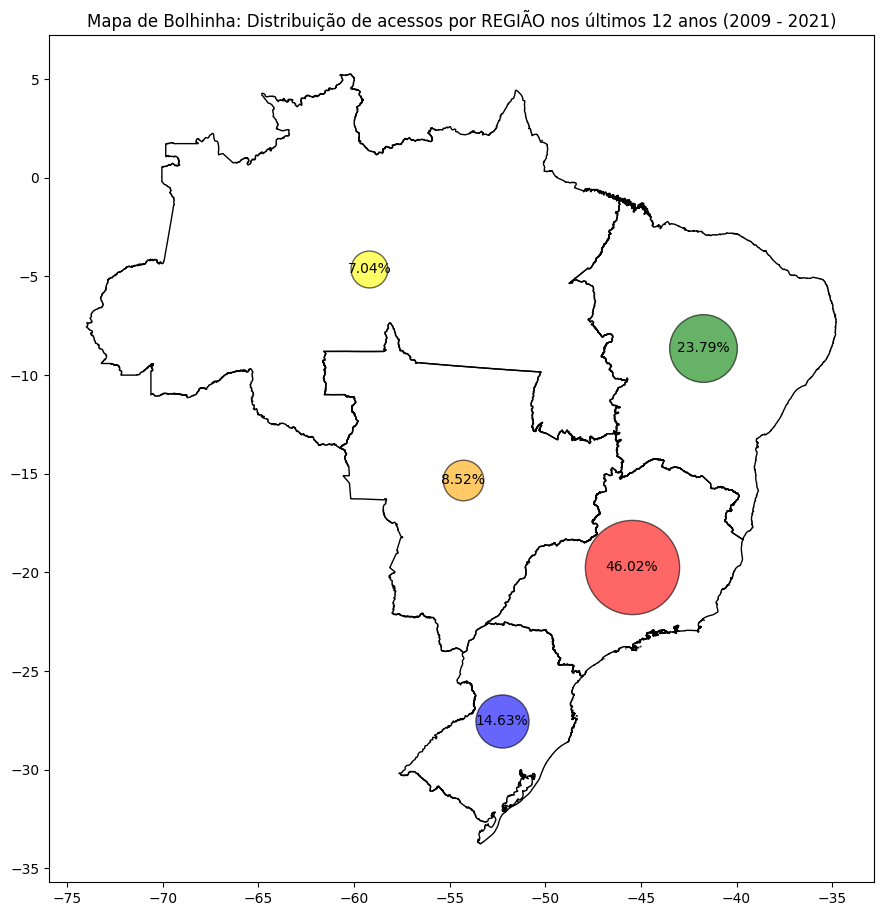

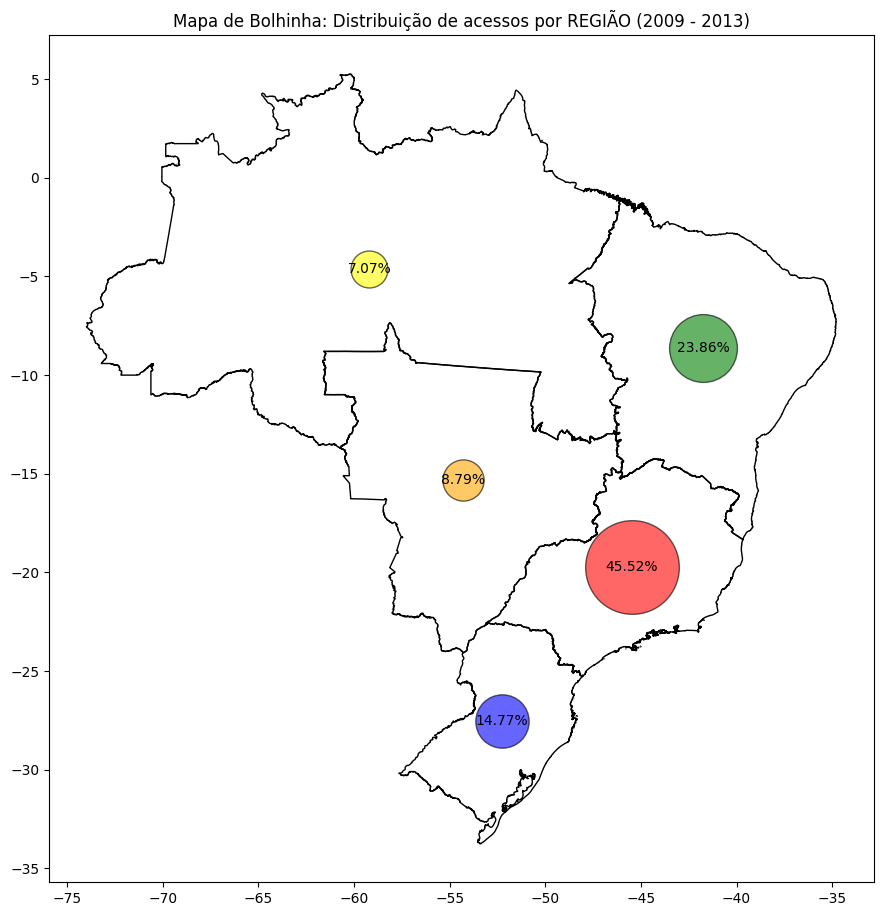

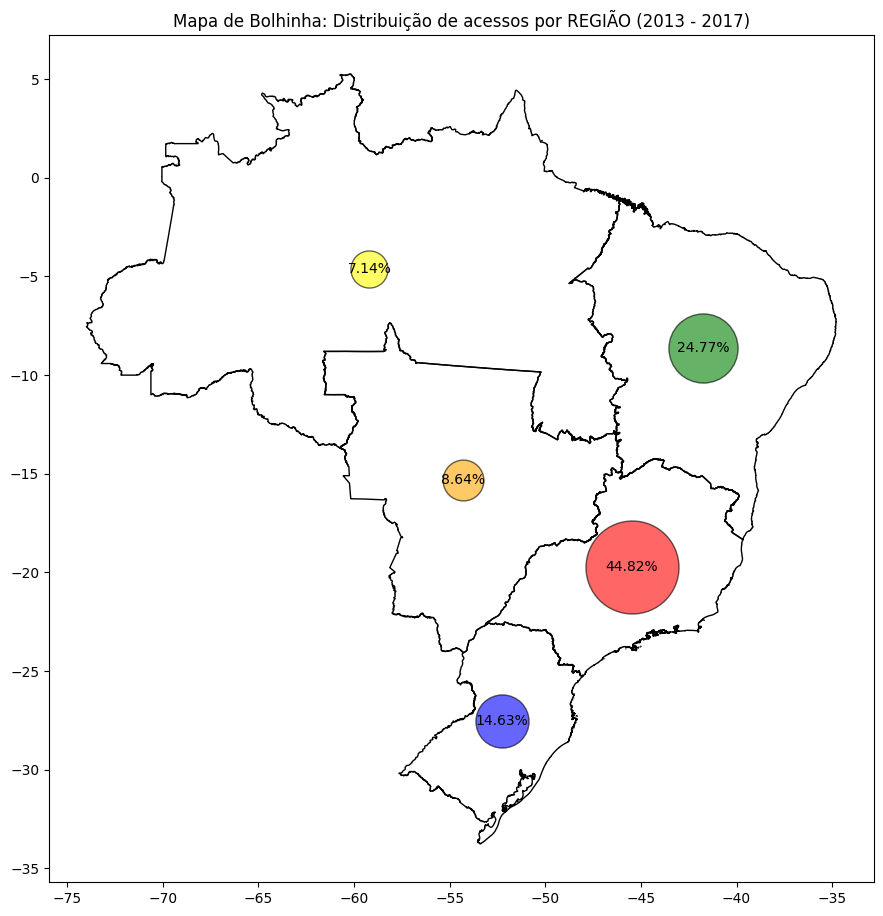

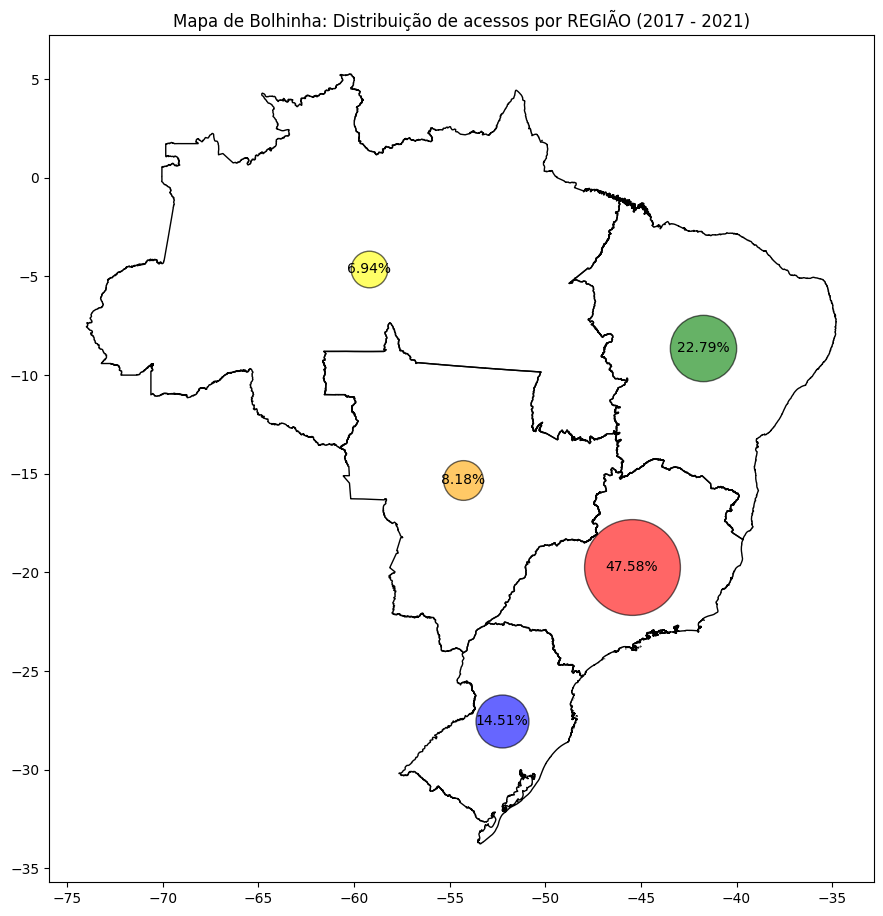

In [8]:
import pandas as pd

f = pd.read_csv('./acessos_dados/br_anatel_telefonia_movel_ddd.csv')

class Utils:
    def format_large_numbers_in_a_list(l:list) -> list:
        for i in range(0, len(l)):
            n = l[i]

            t = 1_000_000_000_000
            b = 1_000_000_000
            m = 1_000_000
            mil = 1_000

            if n >= t:
                l[i] = f'{n/t:.3f} Tri'
            elif n >= b:
                l[i] = f'{n/b:.3f} Bi'
            elif n >= m:
                l[i] = f'{n/m:.3f} M'
            elif n >= mil:
                l[i] = f'{n/mil:.3f} Mil'
            else:
                l[i] = str(l[i])

        return l

    def format_large_number(n: float) -> str:
        t = 1_000_000_000_000
        b = 1_000_000_000
        m = 1_000_000
        mil = 1_000

        if n >= t:
            n = f'{n/t:.3f} Tri'
        elif n >= b:
            n = f'{n/b:.3f} Bi'
        elif n >= m:
            n = f'{n/m:.3f} M'
        elif n >= mil:
            n = f'{n/mil:.3f} Mil'
        else:
            n = str(n)

        return n

    def plotBarGraphic(title:str, x_title:str, y_title:str, x:list, y:list, ytext:list, x_angle = 0) -> None:
        import plotly.graph_objs as go
        import plotly.io as pio

        bg = go.Figure(data=[go.Bar(x=x, y=y, text=ytext, textposition='auto')])

        bg.update_layout(
            title=title,
            title_x=0.5,
            xaxis_title=x_title,
            yaxis_title=y_title,
            xaxis_tickangle=x_angle,
        )

        pio.show(bg)

    def plotPieGraphic(title:str, labels:list, values:list, texts:list=None, textinfo='label+text', textposition='outside', hoverinfo='label+percent', forceTextsInside=False) -> None:
        import plotly.graph_objs as go
        import plotly.io as pio

        pg = go.Figure(data=[go.Pie(labels=labels, values=values, text=texts, textinfo=textinfo, hoverinfo=hoverinfo, textposition=textposition)])
        if texts is not None and forceTextsInside is True:
            pg.add_trace(go.Pie(labels=labels, values=values, text=texts, textinfo='text', textposition='inside', hoverinfo='label+text+percent'))
        pg.update_layout(
            title_text=title,
            title_x = 0.5
        )

        pio.show(pg)

    def plotHeatGraphic(title: str, auxiliarColumn:str, targetColumn: str, values:dict = None, createColumn:bool = False, path:str = './gr/grandes_regioes_shp.shp'):
        import geopandas as gpd
        import matplotlib.pyplot as plt

        f = gpd.read_file(path)

        # settings
        _, ax = plt.subplots(1, 1, figsize=(11, 11))
        f.boundary.plot(ax=ax, color='black')

        if createColumn == True and values is not None:
            f[targetColumn] = f[auxiliarColumn].map(values)

            f.plot(column=targetColumn, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

            plt.title(title)
            plt.show()

    def plotBubbleGraphic(title: str, auxiliarColumn:str, targetColumn: str, values:dict = None, createColumn:bool = True, path:str = './gr/grandes_regioes_shp.shp'):
            import geopandas as gpd
            import matplotlib.pyplot as plt

            colors = {
                'Centro-Oeste': 'orange',
                'Nordeste': 'green',
                'Norte': 'yellow',
                'Sudeste': 'red',
                'Sul': 'blue'
            }

            f = gpd.read_file(path)
            _, ax = plt.subplots(1, 1, figsize=(11, 11))
            f.boundary.plot(ax=ax, linewidth=1, color='black')

            if createColumn == True and values is not None:
                f[targetColumn] = f[auxiliarColumn].map(values)

                scaling_factor = 100  # Ajuste para o tamanho das bolhas
                f['size'] = f['percent'] * scaling_factor

                for _, row in f.iterrows():
                    centroid = row['geometry'].centroid
                    color = colors[row['NOME1']]
                    size = row['size']

                    # Plotar a bolha
                    bubble = ax.scatter(centroid.x, centroid.y, s=size, color=color, alpha=0.6, edgecolor='black')

                    # Adicionar a porcentagem dentro da bolha
                    ax.text(centroid.x, centroid.y, f"{row['percent']:.2f}%", ha='center', va='center', fontsize=10)

                # Ajustar o título e exibir
                plt.title(title)
                plt.show()

class Graphic:
    def tech_signal_all_time_access():
        import numpy as np
        f['tecnologia'].str.strip()
        f['sinal'].str.strip()

        tsg = f.groupby(['tecnologia', 'sinal'])

        x_y = {}

        for (t,s), g in tsg:
            x_y[f'{t} - {s}'] = g['acessos'].sum()

        x_y_copy = {}
        for v in sorted(list(x_y.values())):
            for k, val in x_y.items():
                if v == val:
                    x_y_copy[k] = v

        x_y = x_y_copy

        x = list(x_y.keys())
        y = list(x_y.values())

        yf = Utils.format_large_numbers_in_a_list(y.copy())

        e = f['ano'].max()
        s = f['ano'].min()
        i = e - s

        Utils.plotBarGraphic(
            title = f"Total de acessos por tipo TECNOLOGIA & SINAL nos últimos {i} anos ({s} - {e})",
            x_title = 'Tecnologia - Sinal',
            y_title = 'Total de Acessos',
            x = x,
            y = y,
            ytext = yf,
            x_angle = -45
        )

        x_y_copy = dict(sorted(x_y_copy.items(), key=lambda e: e[1], reverse=True))

        pi = {}
        o = {}

        for k,v in x_y_copy.items():
            p = (v/(f['acessos'].sum()))*100
            if p <= 2:
                o[k] = v
            else:
                pi[k] = v

        t = 0

        for k,v in o.items():
            t += v

        title = f'{len(o)} TECNOLOGIAS & SINAIS distintas'

        pi[title] = t

        x = list(pi.keys())
        y = list(pi.values())
        d = []

        for v in pi.values():
            p = (v / f['acessos'].sum()) * 100
            d.append(f'{Utils.format_large_number(v)} ({p:.2f}%)')

        Utils.plotPieGraphic(
            title = f'Distribuição de acessos por TECNOLOGIA & SINAL nos últimos {i} anos ({s} - {e})',
            labels = x,
            values = y,
            texts = d
        )

        x = list(o.keys())
        y = list(o.values())
        d = []

        for v in o.values():
            p = (v / f['acessos'].sum()) * 100
            d.append(f'{Utils.format_large_number(v)} ({p:.4f}%)')

        Utils.plotPieGraphic(
            title=f'As 11 TECNOLOGIAS E SINAIS DISTINTOS: Os "{(sum(o.values()) / f["acessos"].sum())*100:.2f}%"',
            labels=x,
            values=y,
            texts=d,
            textinfo='label+text',
            hoverinfo='percent'
        )


    def signal_all_time_access():
        f['sinal'].str.strip()

        sg = f.groupby('sinal')

        x_y = {}

        for (s), g in sg:
            x_y[s] = g['acessos'].sum()

        x_y = dict(sorted(x_y.items(), key= lambda e: e[1]))

        x = list(x_y.keys())
        y = list(x_y.values())

        yf = Utils.format_large_numbers_in_a_list(y.copy())

        e = f['ano'].max()
        s = f['ano'].min()
        i = e - s

        Utils.plotBarGraphic(
            title = f"Total de acessos por tipo de SINAL nos últimos {i} anos ({s} - {e})",
            x_title = 'Sinal',
            y_title = 'T. Acessos',
            x = x,
            y = y,
            ytext = yf,
        )

        Utils.plotPieGraphic(
            title = f'Distribuição de acessos por tipo de SINAL nos últimos {i} anos ({s} - {e})',
            labels = x,
            values = y,
            texts = [Utils.format_large_number(v) for v in y],
            textinfo='label+percent',
            textposition='outside',
            forceTextsInside=True
        )

    def access_per_region():
        r = {
            "nordeste": {'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'},
            "sudeste": {'SP', 'RJ', 'ES', 'MG'},
            "centro_oeste": {'DF', 'GO', 'MT', 'MS'},
            "norte" : {'AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'},
            "sul" : {'PR', 'RS', 'SC'}
        }

        t = 0

        for k, v in r.items():
            ra = f[f['sigla_uf'].isin(v)].groupby('sigla_uf')['acessos'].sum().sum()
            t += ra
            r[k] = ra

        if t == f['acessos'].sum():
            r_copy = dict(sorted(r.items(), key=lambda e: e[1]))
            r = r_copy

            x = list(r.keys())
            y = list(r.values())

            yf = Utils.format_large_numbers_in_a_list(y.copy())

            e = f['ano'].max()
            s = f['ano'].min()
            i = e - s

            Utils.plotBarGraphic(
                title = f"Total de acessos por REGIÃO nos últimos {i} anos ({s} - {e})",
                x_title = 'Região',
                y_title = 'Total de Acessos',
                x = x,
                y = y,
                ytext = yf
            )

            Utils.plotPieGraphic(
                title = f'Distribuição de acessos por REGIÃO nos últimos {i} anos ({s} - {e})',
                labels = x,
                values = y,
                texts=[f'{(v/f["acessos"].sum())*100:.2f}%' for v in y],
                textinfo='label',
                forceTextsInside=True
            )

            ord = {
                'Centro-Oeste': None,
                'Nordeste': None,
                'Norte': None,
                'Sudeste': None,
                'Sul': None
            }

            for k, v in ord.items():
                if k == 'Centro-Oeste':
                    val = r_copy['centro_oeste']
                    p = float(f'{(val/f["acessos"].sum()) * 100:.2f}')
                    ord[k] = p
                else:
                    val = r_copy[k.lower()]
                    p = float(f'{(val/f["acessos"].sum()) * 100:.2f}')
                    ord[k] = p

            Utils.plotHeatGraphic(
                path = './gr/grandes_regioes_shp.shp',
                title = f'Mapa de Calor: Distribuição de acessos por REGIÃO nos últimos {i} anos ({s} - {e})',
                auxiliarColumn = 'NOME1',
                targetColumn = 'percent',
                values = ord,
                createColumn = True
            )

            Utils.plotBubbleGraphic(
                title = f'Mapa de Bolhinha: Distribuição de acessos por REGIÃO nos últimos {i} anos ({s} - {e})',
                auxiliarColumn = 'NOME1',
                targetColumn = 'percent',
                values = ord,
            )

            r = {
                "Centro-Oeste": {'DF', 'GO', 'MT', 'MS'},
                "Nordeste": {'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'},
                "Norte" : {'AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'},
                "Sudeste": {'SP', 'RJ', 'ES', 'MG'},
                "Sul" : {'PR', 'RS', 'SC'}
            }

            p1 = {}
            p2 = {}
            p3 = {}

            for k, v in r.items():
                a1 = f[(f["ano"].isin([2009, 2010, 2011, 2012, 2013])) & (f["sigla_uf"].isin(v))]["acessos"].sum()
                a2 = f[(f["ano"].isin([2013, 2014, 2015, 2016, 2017])) & (f["sigla_uf"].isin(v))]["acessos"].sum()
                a3 = f[(f["ano"].isin([2017, 2018, 2019, 2020, 2021])) & (f["sigla_uf"].isin(v))]["acessos"].sum()
                a1 = float(f'{(a1/f[f["ano"].isin([2009, 2010, 2011, 2012, 2013])]["acessos"].sum()) * 100:.2f}')
                a2 = float(f'{(a2/f[f["ano"].isin([2013, 2014, 2015, 2016, 2017])]["acessos"].sum()) * 100:.2f}')
                a3 = float(f'{(a3/f[f["ano"].isin([2017, 2018, 2019, 2020, 2021])]["acessos"].sum()) * 100:.2f}')
                p1[k] = a1
                p2[k] = a2
                p3[k] = a3


            Utils.plotBubbleGraphic(
                title = f'Mapa de Bolinha: Distribuição de acessos por REGIÃO (2009 - 2013)',
                auxiliarColumn = 'NOME1',
                targetColumn = 'percent',
                values = p1,
            )

            Utils.plotBubbleGraphic(
                title = f'Mapa de Bolinha: Distribuição de acessos por REGIÃO (2013 - 2017)',
                auxiliarColumn = 'NOME1',
                targetColumn = 'percent',
                values = p2,
            )

            Utils.plotBubbleGraphic(
                title = f'Mapa de Bolinha: Distribuição de acessos por REGIÃO (2017 - 2021)',
                auxiliarColumn = 'NOME1',
                targetColumn = 'percent',
                values = p3,
            )

            import plotly.graph_objects as go
            import numpy as np

            r = {
                "Centro-Oeste": {'DF', 'GO', 'MT', 'MS'},
                "Nordeste": {'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'},
                "Norte" : {'AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'},
                "Sudeste": {'SP', 'RJ', 'ES', 'MG'},
                "Sul" : {'PR', 'RS', 'SC'}
            }

            m = {
                'Janeiro' : 1,
                'Fevereiro' : 2,
                'Março' : 3,
                'Abril' : 4,
                'Maio' : 5,
                'Junho' : 6,
                'Julho' : 7,
                'Agosto' : 8,
                'Setembro' : 9,
                'Outubro' : 10,
                'Novembro' : 11,
                'Dezembro' : 12
            }

            r_copy1 = {
                "Centro-Oeste": {},
                "Nordeste": {},
                "Norte" : {},
                "Sudeste": {},
                "Sul" : {}
            }

            # 2009 ~ 2013
            for k,v in r.items():
                d = {}
                for s, i in m.items():
                    a = f[(f['ano'].isin([2009, 2010, 2011, 2012, 2013]) & (f['sigla_uf'].isin(v)) & (f['mes'] == i))]['acessos'].sum()
                    d[s] = int(a / 5)
                r_copy1[k] = d


            data = r_copy1

            d_copy = {}

            for k, v in data.items():
                d_copy[k] = sum(v.values())

            d_copy = dict(sorted(d_copy.items(), key= lambda e: e[1], reverse=True))

            d_copy2 = {}

            for k in d_copy.keys():
                d_copy2[k] = data[k]

            data = d_copy2


            # Configurar os meses
            meses = list(data['Centro-Oeste'].keys())

            # Criar a figura
            fig = go.Figure()

            # Iterar sobre cada região e adicionar linhas de tendência
            for regiao, valores in data.items():
                # Obter os valores de cada região
                valores_float = [v for v in valores.values()]

                # Formatando os valores para o hover
                valores_formatados = [Utils.format_large_number(v) for v in valores_float]

                fig.add_trace(go.Scatter(
                    x=meses,
                    y=valores_float,
                    mode='lines+markers',
                    name=regiao,
                    text=valores_formatados,  # Adiciona texto formatado aos pontos
                    hoverinfo='text',  # Mostra o texto ao passar o mouse
                    hovertext=valores_formatados  # Garante que o hover exiba os valores em ordem correta
                ))

            # Configurações do layout
            fig.update_layout(
                title='Média Mensal de acessos no perído de (2009 - 2013)',
                xaxis_title='Meses',
                yaxis_title='Valores (em milhões)',
                legend_title='Regiões',
                template='plotly_white',  # Template para um fundo claro
                hovermode='x unified',  # Unifica o hover para todas as linhas
            )

            # Mostrar o gráfico
            fig.show()

            # 2013 ~ 2017
            for k,v in r.items():
                d = {}
                for s, i in m.items():
                    a = f[(f['ano'].isin([2013, 2014, 2015, 2016, 2017]) & (f['sigla_uf'].isin(v)) & (f['mes'] == i))]['acessos'].sum()
                    d[s] = int(a / 5)
                r_copy1[k] = d


            data = r_copy1

            d_copy = {}

            for k, v in data.items():
                d_copy[k] = sum(v.values())

            d_copy = dict(sorted(d_copy.items(), key= lambda e: e[1], reverse=True))

            d_copy2 = {}

            for k in d_copy.keys():
                d_copy2[k] = data[k]

            data = d_copy2


            # Configurar os meses
            meses = list(data['Centro-Oeste'].keys())

            # Criar a figura
            fig = go.Figure()

            # Iterar sobre cada região e adicionar linhas de tendência
            for regiao, valores in data.items():
                # Obter os valores de cada região
                valores_float = [v for v in valores.values()]

                # Formatando os valores para o hover
                valores_formatados = [Utils.format_large_number(v) for v in valores_float]

                fig.add_trace(go.Scatter(
                    x=meses,
                    y=valores_float,
                    mode='lines+markers',
                    name=regiao,
                    text=valores_formatados,  # Adiciona texto formatado aos pontos
                    hoverinfo='text',  # Mostra o texto ao passar o mouse
                    hovertext=valores_formatados  # Garante que o hover exiba os valores em ordem correta
                ))

            # Configurações do layout
            fig.update_layout(
                title='Média Mensal de acessos no perído de (2013 - 2017)',
                xaxis_title='Meses',
                yaxis_title='Valores (em milhões)',
                legend_title='Regiões',
                template='plotly_white',  # Template para um fundo claro
                hovermode='x unified',  # Unifica o hover para todas as linhas
            )

            # Mostrar o gráfico
            fig.show()

            # 2017 ~ 2021
            for k,v in r.items():
                d = {}
                for s, i in m.items():
                    a = f[(f['ano'].isin([2017, 2018, 2019, 2020, 2021]) & (f['sigla_uf'].isin(v)) & (f['mes'] == i))]['acessos'].sum()
                    d[s] = int(a / 5)
                r_copy1[k] = d


            data = r_copy1

            d_copy = {}

            for k, v in data.items():
                d_copy[k] = sum(v.values())

            d_copy = dict(sorted(d_copy.items(), key= lambda e: e[1], reverse=True))

            d_copy2 = {}

            for k in d_copy.keys():
                d_copy2[k] = data[k]

            data = d_copy2


            # Configurar os meses
            meses = list(data['Centro-Oeste'].keys())

            # Criar a figura
            fig = go.Figure()

            # Iterar sobre cada região e adicionar linhas de tendência
            for regiao, valores in data.items():
                # Obter os valores de cada região
                valores_float = [v for v in valores.values()]

                # Formatando os valores para o hover
                valores_formatados = [Utils.format_large_number(v) for v in valores_float]

                fig.add_trace(go.Scatter(
                    x=meses,
                    y=valores_float,
                    mode='lines+markers',
                    name=regiao,
                    text=valores_formatados,  # Adiciona texto formatado aos pontos
                    hoverinfo='text',  # Mostra o texto ao passar o mouse
                    hovertext=valores_formatados  # Garante que o hover exiba os valores em ordem correta
                ))

            # Configurações do layout
            fig.update_layout(
                title='Média Mensal de acessos no perído de (2017 - 2021)',
                xaxis_title='Meses',
                yaxis_title='Valores (em milhões)',
                legend_title='Regiões',
                template='plotly_white',  # Template para um fundo claro
                hovermode='x unified',  # Unifica o hover para todas as linhas
            )

            # Mostrar o gráfico
            fig.show()








Graphic.tech_signal_all_time_access()
Graphic.signal_all_time_access()
Graphic.access_per_region()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



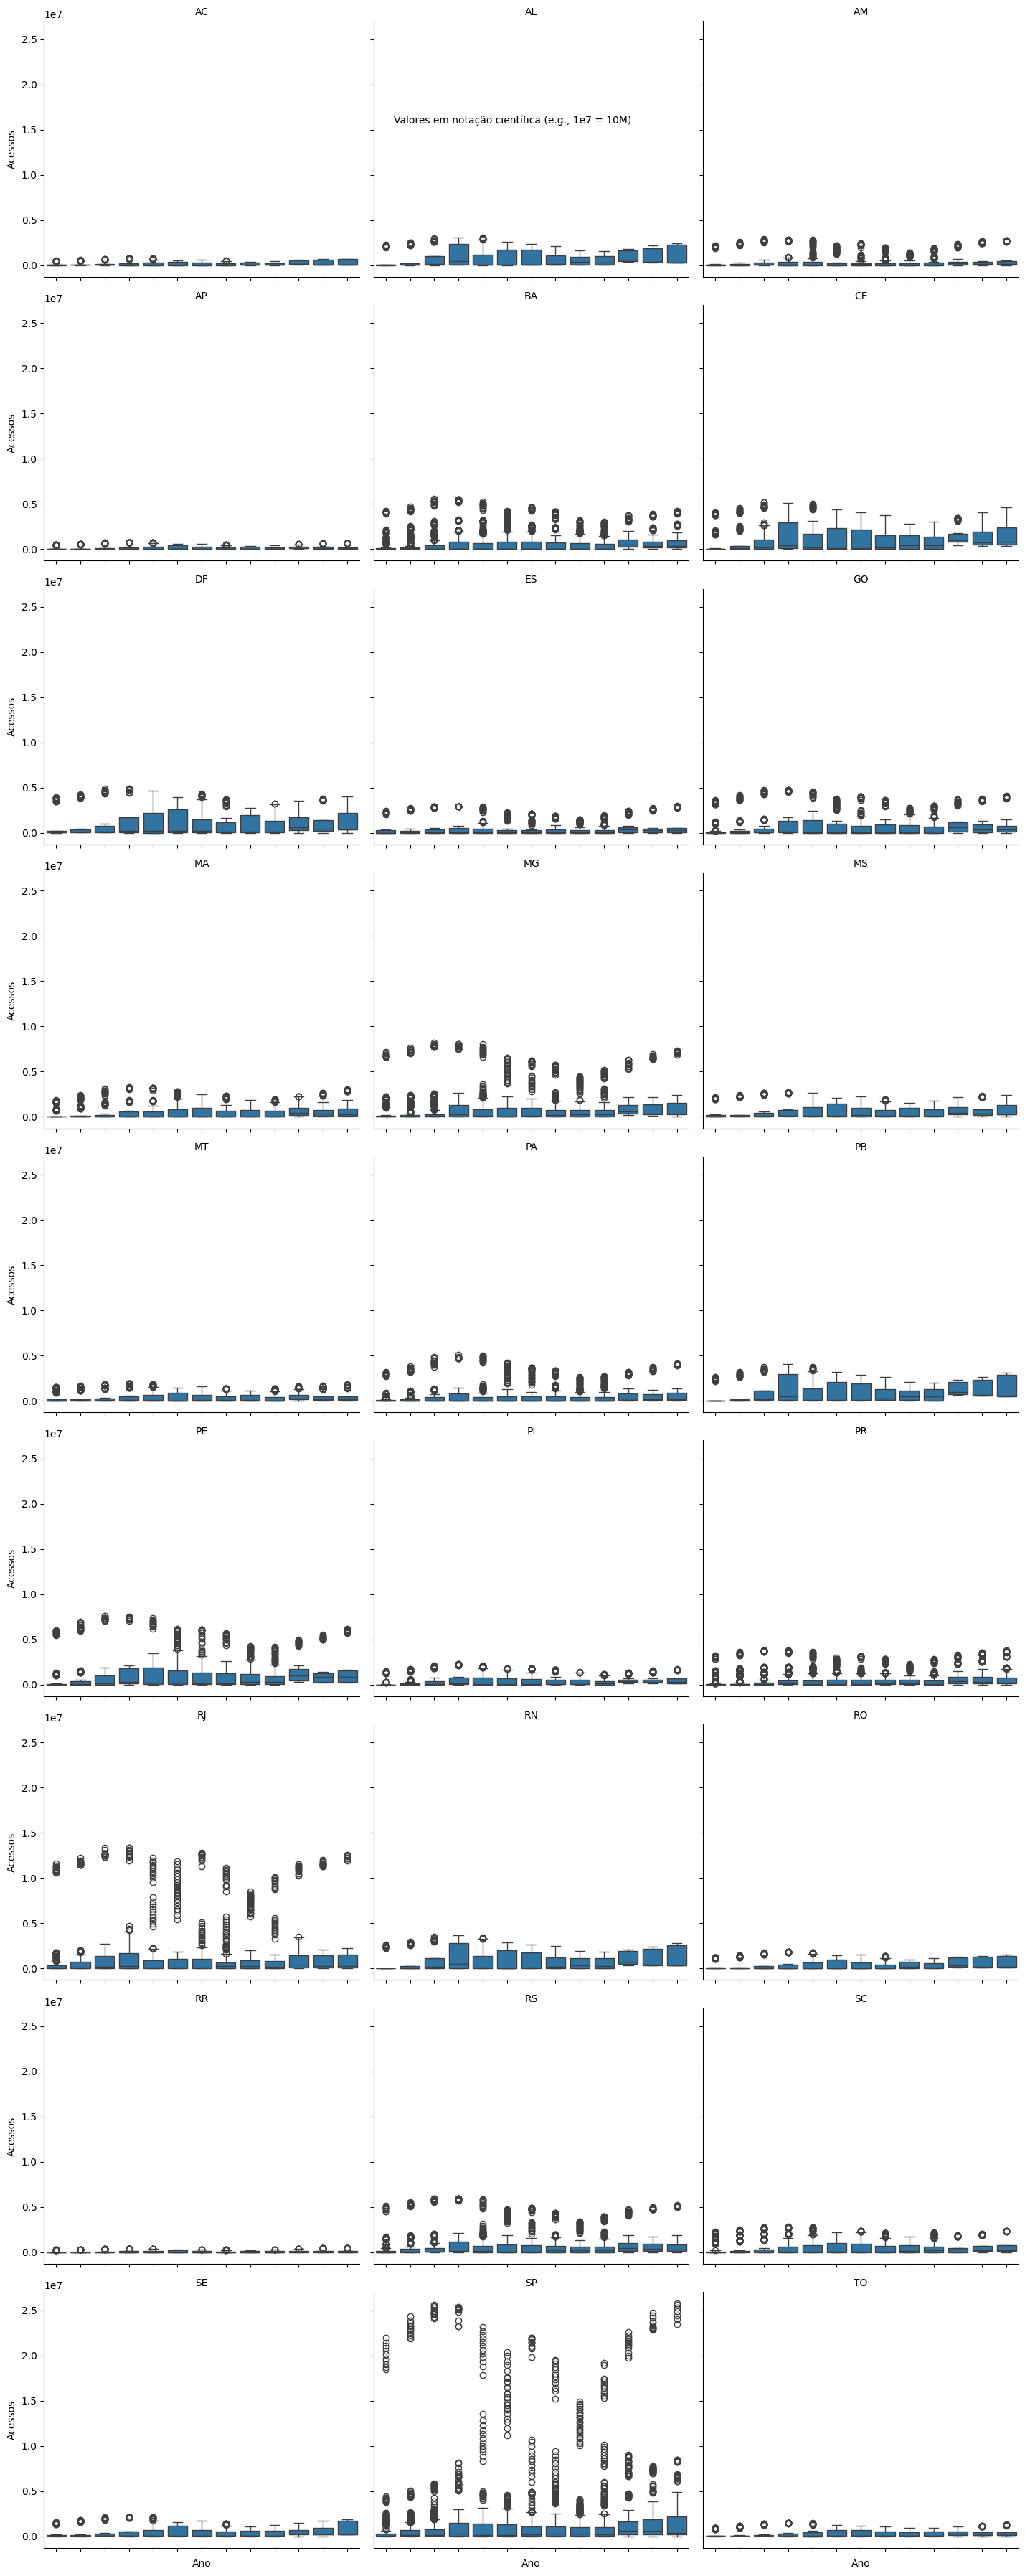

In [19]:
# Gráfico para identificar o número de acessos OUTLIERS de cada estado brasileiro (UFs)

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(f, col='sigla_uf', col_wrap=3, height=4, aspect=1.2)
g.map(sns.boxplot, 'ano', 'acessos')

g.set_titles("{col_name}")
g.set_axis_labels("Ano", "Acessos")
g.set_xticklabels(rotation=45)
plt.figtext(0.5, 0.95, "Valores em notação científica (e.g., 1e7 = 10M)", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

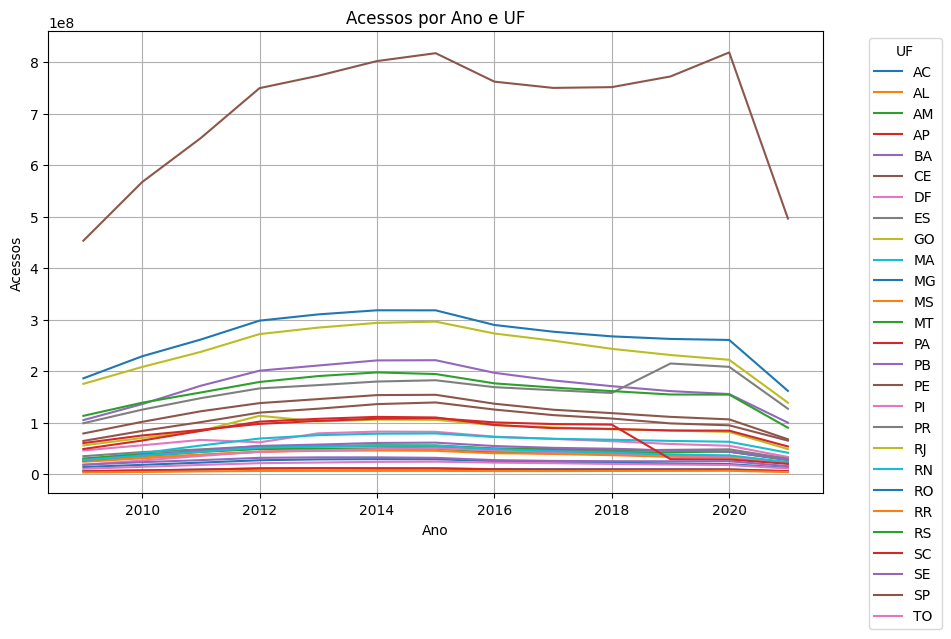

In [14]:
# Gráfico geral para identificar os estados OUTLIERS dos dados de acessos por ano

import pandas as pd
import matplotlib.pyplot as plt

grouped_ano_uf = f.groupby(['ano', 'sigla_uf'])['acessos'].sum().reset_index()

plt.figure(figsize=(10, 6))
for uf in grouped_ano_uf['sigla_uf'].unique():
    subset = grouped_ano_uf[grouped_ano_uf['sigla_uf'] == uf]
    plt.plot(subset['ano'], subset['acessos'], label=uf)

plt.title('Acessos por Ano e UF')
plt.xlabel('Ano')
plt.ylabel('Acessos')
plt.legend(title='UF', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()